In [110]:
import numpy as np
import pandas as pd 
import scipy
import types
from itertools import combinations
import pylab as plt

In [18]:
# input: string or list, int
# output: list of tuples
# This function returns all the combination of the characters in the string 
# of length k as a list of tuples. It can also take a list as its first 
# argument and has the same output but treats the elements of the list 
# like characters in a string. It should be noted that this function
# "renames" the function combinations of the itertools library
# so it is more readable to the user.
def alphabet_choose_k(alphabet, k):
    return list(combinations(alphabet, k))

In [19]:
# input: list of same length tuples
# output: matrix
# Takes in a tuple list each of the same size k which are all the 
# combinations of our variables and calculates the adjacency matrix
# of its Johnson Graph 
def calc_adj_mat(tuple_list):
    # type check the tuple list
    if isinstance(tuple_list, list)==False:
        return("Argument is not a list!")
    # Create adjacency matrix of size of the amount of tuples in the 
    # list on both columns and rows
    dim = len(tuple_list)       
    Adj = np.zeros((dim,dim))
    # Go through the matrix 
    for i in range(dim):
        for j in range(dim):
            # if the intersection of the nodes (which are the tuples) 
            # is equal to their length - 1 then they are connected
            # and we put a one in the matrix to represent that connection
            if len(set(tuple_list[i]).intersection(set(tuple_list[j]))) == len(tuple_list[0])-1:
                Adj[i,j] = 1
    return Adj

In [20]:
# input: matrix
# output: list of floats, list of arrays
# Takes in an adjacency matrix (which is symmetric) and calculates
# the eigen values and eigen vectors and returns them as a list of floats
# and as a list of arrays respectively. It should be noted that the 
# eigen values corrspond with the same indexed eigen vectors.
# This function "renames" the function np.linalg.eigh for the
# purpose of making it easier for the user.
def calc_eig_vec_of_adj_matrix(mat):
    eig_val, eig_vec = np.linalg.eigh(mat)
    return eig_val, eig_vec

In [21]:
# input: list of floats
# output: list of arrays
# Since the eigen vectors corresponding to the same M_i in a 
# given decomposition (n,k) have the same eigen value, this
# function (that takes in eigen vectors and eigen values in 
# order of correspondance) concatenates (as matrices) eigen 
# vectors that correspond to the same M_i and returns these 
# as a list of matricies that are the basis for the M_i's
# in ascending order (i.e. [M_0, M_1,...,M_k])
def group_eig_vecs(e_vals, e_vecs):
    # gather the distinct eigen values and sort them
    distinct_vals = np.unique(e_vals.round(decimals=4))
    distinct_vals = np.sort(distinct_vals)
    # create empty list where we will store the basis
    M_basis = []
    # for every distinct eigen value we will go through the 
    # list of eigen values and if they are equal we will add the
    # corresponding eigen vector to a list 
    for val in distinct_vals:
        # list for storing eigen vectors that correspond to 
        # the same M_i
        vec_list = []
        for i in range(len(e_vals)):
            if(val == e_vals[i].round(decimals=4)):
                vec_list.append(np.transpose(e_vecs)[i])
        # transform list of arrays into matrix to append to M basis list
        vec_list = np.array(vec_list).reshape(len(vec_list), len(vec_list[0]))
        M_basis.append(vec_list)
    # return M basis
    M_basis = np.flipud(M_basis)
    return M_basis

In [22]:
# input: array, list of matrices
# output: list of arrays
# This functions calculates the projection of the data vector 
# f onto each of the M_i basis (in the form of a matrix)
def proj_f_onto_M(f, M_basis):
    # emptylist to store the f_is as we calculate them 
    f_is = []
    # for every element of the list of M basis we will 
    # calculate f_i and append it to the list
    for i in range(len(M_basis)):
        f_is.append(proj_onto_M_i(f, M_basis[i]))
    # return list of f_i's
    return f_is

# input: array, matrix
# output: array
# This function takes in a data vector and a basis for M_i and 
# projects f onto that basis to calculate f_i
def proj_onto_M_i(f, M_i):
    # get the dimensions of M_i
    nrow = M_i.shape[0]
    ncol = M_i.shape[1]
    # create a zero vector to add the projections calculated by
    # components in the eigen vectors 
    f_i = np.zeros(ncol)
    # for each row of the basis (recall we saved the eigen vectors
    # as lines) we calculare the projections
    for j in range(nrow):
        # temporarily reshape the row to transform it from an array
        # to a one dimentional matrix (vertical)
        tmp = np.copy(M_i[j])
        tmp = tmp.reshape(10,1)
        # add the new projection to f_i
        f_i = f_i + project(f, tmp)
    # return f_i
    return f_i
    
# input: one dimentional matrix, array
# output: one dimentional matrix
# This funtion calculates the projection of f onto b
def project(f, v):
    # reshape v to be a one dimentional matrix compatible 
    # for dot (or inner) product (horizontal)
    v = v.reshape(1,10)
    # calculate projection and return it
    result = (np.dot(v,f)/np.dot(v,np.transpose(v)))*v
    return result

In [65]:
def Mallows_list(alphabet, f_iList, partition):
    k = partition[1]
    MallowsList = [f_iList[0]]
    for f_iIndex in range(1,k):
        MallowsList.append(calc_Mallow(alphabet, f_iList[f_iIndex], f_iIndex, k))
    MallowsList.append(f_iList[-1])
    return MallowsList
    
def calc_Mallow(alphabet, f_i, i, k):
    rows = list(combinations(alphabet, i))
    cols = alphabet_choose_k(alphabet, k)
    Mallow_f_i = np.zeros(len(rows))
    for iElem in range(len(rows)):
        for kElem in range(len(cols)):
            if(set(rows[iElem]).issubset(set(cols[kElem]))):
                Mallow_f_i[iElem] = Mallow_f_i[iElem] + f_i[0,kElem]
    return Mallow_f_i

In [260]:
def categorize_row(row):
    tempRow = np.copy(row)
    tempRow = np.asarray(tempRow[0])
    length = len(tempRow)-1 # we dont want to include the hemoglobin
    category = []
    for i in range(length):
        if(int(tempRow[i]) == 0):
            category.append(i)
    
    if(len(category) != 1):
        print("TUPLE")
        return tuple(category)
    else:
        return category[0]

In [261]:
def calc_f(PartitionTuple):
    k = PartitionTuple[0]
    data = PartitionTuple[1]
    nrows = data.shape[0]
    nvars = data.shape[1]-1
    rowCategory = [0]*nvars
    singles = []
    lexOrder = list(combinations(list(range(nvars)),nvars-k))
    f = np.zeros(int(scipy.special.binom(nvars,nvars-k)))
    for row in range(nrows):
        cat = categorize_row(data[row,])
        if(isinstance(cat, tuple)):
#             print("TUP")
            rowCategory.append(cat)
        else:
#             print("ELSE")
            singles.append(cat)
#     print("row cat = ", rowCategory)
    for row in range(nrows):
        for order in range(len(lexOrder)):
            if(rowCategory[row] == lexOrder[order]):
                f[order] = f[order] + data[row,-1]
#     print("ind = ", singles)
    for i in range(len(singles)):
        f[i] = singles[i]
    return f

In [262]:
def create_data_vectors(PartitionList):
    dataVectors = []
    for data in range(len(PartitionList)):
        dataVectors.append(calc_f(PartitionList[data]))
    return dataVectors

In [263]:
def num_of_mutations(RDM):
    tempRDM = np.copy(RDM)
    tempRDM = np.delete(tempRDM,-1,1)
    nones = []
    nrows = RDM.shape[0]
    for row in range(nrows):
        nones.append(sum(tempRDM[row,]))
    nzeros = [tempRDM.shape[1]]*(len(nones))
    nzeros = [a_i - b_i for a_i, b_i in zip(nzeros, nones)]
    return nzeros

In [264]:
def raw_data_partitions(RDM, nzeros):
    nrows = RDM.shape[0]
    ncols = RDM.shape[1]
    fPartitions = []
    distinct_amounts_zeros = np.unique(nzeros)
    distinct_amounts_zeros = np.sort(distinct_amounts_zeros)
    for amount in distinct_amounts_zeros:
        list_amount_i = []
        for row in range(nrows):
            if(nzeros[row]==amount):
                list_amount_i.append(RDM[row,])
        Matrix_amount_i = np.concatenate(list_amount_i)
        fPartitions.append((amount,
                            Matrix_amount_i))
    return fPartitions

In [265]:
example = np.matrix([[0, 1, 1, 1, 1],[1, 1, 0, 1, 1],[1, 0, 1, 0, 1],
                     [1, 0, 0, 1, 1],[1, 1, 1, 0, 1],[0, 1, 1, 0, 1],
                     [1, 1, 1, 0, 1],[1, 0, 0, 1, 1],[1, 1, 1, 0, 1],
                     [1, 0, 0, 1, 1]])
n0s = num_of_mutations(example)
fs = raw_data_partitions(example, n0s)
fs = create_data_vectors(fs)
fs

IndexError: list index out of range

In [69]:
# validate code with example from reference [2] (see technical report)
pairs = alphabet_choose_k('ABCDE', 2)
Adj = calc_adj_mat(pairs)
vals, vecs = calc_eig_vec_of_adj_matrix(Adj)
Mbasis = group_eig_vecs(vals, vecs)
f = np.array([11,10,4,7,9,7,6,24,17,15]).reshape(10,1)
f_list = proj_f_onto_M(f, Mbasis)
#print(f_list)
MalList = Mallows_list('ABCDE',f_list, (5,2))
MalList

[array([[ 11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.]]),
 array([-12., -11.,  16.,   6.,   1.]),
 array([[ 7.66666667, -2.33333333, -5.        , -0.33333333, -3.66666667,
         -2.33333333, -1.66666667,  5.66666667,  0.33333333,  1.66666667]])]

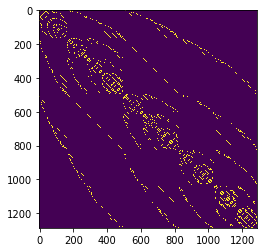

In [97]:
plt.imshow(Adj)
plt.show()

In [244]:
a = [1,2,3]
a*3

[1, 2, 3, 1, 2, 3, 1, 2, 3]

In [108]:
nCr(4,2)

NameError: name 'nCr' is not defined